In [1]:
import sys
import numpy as np
import pandas as pd
from scipy.misc import imread
import pickle
import os
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

Using TensorFlow backend.


In [2]:
train_folder= "train"
test_folder = "test"

In [3]:
def loadimgs(path):
    X=[]
    y=[]
    curr_y=1
    p = os.path.join(path)
    for folders in os.listdir(p):
        images_path = os.path.join(p,folders)
        category_images=[]
        for image in os.listdir(images_path):
            im_path = os.path.join(images_path,image)
            image = imageio.imread(im_path)
            category_images.append(image)
            y.append(curr_y)
        try:
            X.append(np.stack(category_images))
        except ValueError as e:
            print(e)
        curr_y+=1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y

In [4]:
X_train,y_train = loadimgs(train_folder)
X_test,y_test = loadimgs(test_folder)

In [5]:
def initialize_weights(shape,name=None):
    return np.random.normal(loc=0.0,scale=1e-2,size=shape)

In [54]:
def initialize_bias(shape,name=None):
return np.random.normal(loc=0.5,scale=1e-2,size=shape)

IndentationError: expected an indented block (<ipython-input-54-66a84de963bf>, line 2)

In [70]:
def get_siamese_model(input_shape):
    left_input=Input(input_shape)
    right_input=Input(input_shape)
    
    model = Sequential()
    model.add(Conv2D(8,(16,11), activation='relu', input_shape=input_shape,
                    kernel_initializer=initialize_weights,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(16,(11,9), activation='relu', input_shape=input_shape,
                    kernel_initializer=initialize_weights,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32,(5,5), activation='relu', input_shape=input_shape,
                    kernel_initializer=initialize_weights,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(64,(4,5), activation='relu', input_shape=input_shape,
                    kernel_initializer=initialize_weights,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128,(3,3), activation='relu', input_shape=input_shape,
                    kernel_initializer=initialize_weights,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(2048,activation='sigmoid',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    model.add(Dense(128,activation='sigmoid',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    encoded_l=model(left_input)
    encoded_r=model(right_input)
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0]-tensors[1]))
    L1_distance=L1_layer([encoded_l,encoded_r])
    
    prediction=Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    return siamese_net

In [72]:
model = get_siamese_model((400,275,1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 400, 275, 1)  0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 400, 275, 1)  0                                            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 128)          12202616    input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 128)          0           sequential_9[1][0]               
          

In [9]:
optimizer = Adam(lr=0.00006)
model.compile(loss='binary_crossentropy',optimizer=optimizer)

In [10]:
def get_batch(batch_size,s="train"):
    if s=='train':
        X = X_train
    else:
        X = X_test
    
    n_classes,n_examples,w,h = X.shape
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    pairs = [np.zeros((batch_size,w,h,1)) for i in range(2)]
    targets=np.zeros((batch_size,))
    targets[batch_size//2:]=1
    for i in range(batch_size):
        category = categories[i]
        id1=rng.randint(0,n_examples)
        pairs[0][i,:,:,:]=X[category,id1].reshape(w,h,1)
        id2=rng.randint(0,n_examples)
        
        if i>=batch_size//2:
            category_2=category
        else:
            category_2=(category+rng.randint(1,n_classes))%n_classes
        
        pairs[1][i,:,:,:]=X[category_2,id2].reshape(w,h,1)
    
    return pairs,targets

In [11]:
def generate(batch_size,s="train"):
    while True:
        pairs,targets = get_batch(batch_size,s)
        yield (pairs,targets)

In [12]:
def make_oneshot_task(N,s="val"):
    if s=='train':
        X = X_train
    else:
        X = X_test
    n_classes,n_examples,w,h = X.shape
    indices = rng.randint(0,n_examples,size=(N,))
    categories = rng.choice(range(n_classes),size=(N,),replace=False)
    true_category = categories[0]
    ex1,ex2 = rng.choice(n_examples,size=(2,),replace=False)
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N,w,h,1)
    support_set= X[categories,indices,:,:]
    support_set[0,:,:]=X[true_category,ex2]
    support_set = support_set.reshape(N,w,h,1)
    targets = np.zeros((N,))
    targets[0]=1
    targets,test_image,support_set = shuffle(targets,test_image,support_set)
    pairs = [test_image,support_set]
    return pairs,targets

In [13]:
def test_oneshot(model,N,k,s='val',verbose=0):
    n_correct=0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks...".format(k,N))
    for i in range(k):
        inputs,targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs)==np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0*n_correct/k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy\n".format(percent_correct,N))
    return percent_correct

In [14]:
evaluate_every = 200
batch_size = 8
n_iter = 2000
N_way = 4
n_val = 250
best = -1

In [15]:
model_path = './weights/'

In [16]:
print("Starting training process!")
print("--------------------------------------------------------------------")
t_start = time.time()
for i in range(1,n_iter+1):
    (inputs,targets)=get_batch(batch_size)
    loss = model.train_on_batch(inputs,targets)
    if i%evaluate_every == 0:
        print("---------------------------------------------")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
--------------------------------------------------------------------
Instructions for updating:
Use tf.cast instead.
---------------------------------------------
Time for 200 iterations: 6.836723192532857 mins
Train Loss: 0.8354560732841492
Evaluating model on 250 random 4 way one-shot learning tasks...
Got an average of 68.8% 4 way one-shot learning accuracy

Current best: 68.8, previous best: -1
---------------------------------------------
Time for 400 iterations: 14.283040241400402 mins
Train Loss: 0.5600456595420837
Evaluating model on 250 random 4 way one-shot learning tasks...
Got an average of 76.8% 4 way one-shot learning accuracy

Current best: 76.8, previous best: 68.8
---------------------------------------------
Time for 600 iterations: 21.571604943275453 mins
Train Loss: 0.48990046977996826
Evaluating model on 250 random 4 way one-shot learning tasks...
Got an average of 85.6% 4 way one-shot learning accuracy

Current best: 85.6, previous best:

In [17]:
ways = np.arange(1,10,2)
trials = 50

In [18]:
val_accs, train_accs = [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks...
Got an average of 100.0% 1 way one-shot learning accuracy

Evaluating model on 50 random 1 way one-shot learning tasks...
Got an average of 100.0% 1 way one-shot learning accuracy

---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 3 way one-shot learning tasks...
Got an average of 90.0% 3 way one-shot learning accuracy

Evaluating model on 50 random 3 way one-shot learning tasks...
Got an average of 96.0% 3 way one-shot learning accuracy

---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 5 way one-shot learning tasks...
Got an average of 84.0% 5 way one-shot learning accuracy

Evaluating model on 50 random 5 way one-shot learning tasks...
Got an average of 84.0% 5 way one-shot learning accuracy

------------------------------------------------

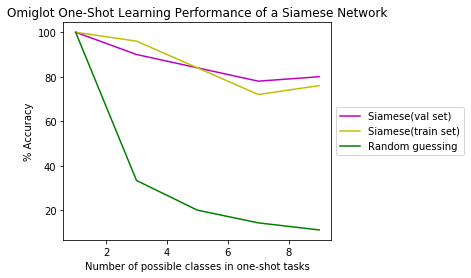

In [19]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [74]:
model.layers.pop(0)
model.layers.pop()
model.layers.pop()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 400, 275, 1)  0                                            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 128)          12202616    input_17[0][0]                   
                                                                 input_18[0][0]                   
Total params: 12,202,616
Trainable params: 12,202,616
Non-trainable params: 0
__________________________________________________________________________________________________


In [75]:
model.build((400,275,1))

In [76]:
img = imageio.imread('1a.jpg')

In [49]:
l=[]
l.append(img)
l.append(img)

In [51]:
l=np.array(l)

In [52]:
l.shape

(2, 400, 275)

In [77]:
model.predict(img)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [Array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255...

In [78]:
from keras.datasets import mnist

In [79]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 171s 15us/step


In [ ]:
x_train.shape